## Lab 2: Classification
Group 2 Team Members:

- Name 1: Aniketh Vankina
- Name 2: Indy Dhillon 
- Name 3: Jason Rupp 
- Name 4: Suchismita Moharana 

## Data Preparation

In [7]:
#Loading Libraries

import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]


df = pd.read_csv('/Users/password1234/Documents/Machine Learning/census-income.data.csv', header=None, names=header_names)
df_test = pd.read_csv('/Users/password1234/Documents/Machine Learning/census-income.test.csv', header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df.drop(columns=['instance_weight']) ## not used for our analysis

categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

In [9]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'region_prev_res',
        'state_prev_res',
        'det_hh_fam_stat',
        'det_hh_summ',
        'mig_chg_msa',
        'mig_chg_reg',
        'mig_move_reg',
        'mig_same',
        'mig_prev_sunbelt',
        'country_father',
        'country_mother',
        'country_self',
        'year',
    ]
)

In [10]:
# This is section one of the data processing, will be using the same data as shown in the minilab
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299285 entries, 0 to 99761
Data columns (total 29 columns):
age                 299285 non-null int64
class_worker        299285 non-null category
det_ind_code        299285 non-null category
det_occ_code        299285 non-null category
education           299285 non-null category
wage_per_hour       299285 non-null int64
hs_college          299285 non-null category
marital_stat        299285 non-null category
major_ind_code      299285 non-null category
major_occ_code      299285 non-null category
race                299285 non-null category
hisp_origin         299285 non-null category
sex                 299285 non-null category
union_member        299285 non-null category
unemp_reason        299285 non-null category
full_or_part_emp    299285 non-null category
capital_gains       299285 non-null int64
capital_losses      299285 non-null int64
stock_dividends     299285 non-null int64
tax_filer_stat      299285 non-null category
insta

### Data Preperation Part 2

In [11]:
# Sampling the dataset
selection_df = df.sample(frac = .005)

In [12]:
selection_df.shape

(1496, 29)

In [13]:
def preprocess_pipeline(numeric_features, categorical_features):
    ### Scale numerical, one hot categorical

    numeric_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    preprocess_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
        ]
    )
    
    return preprocess_pipe

In [14]:
### Preprocess the data
target = 'income_50k'
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object','bool', 'category']).drop([target], axis=1).columns
X_selection = selection_df.drop(target, axis=1)
y_selection = selection_df[target]
preprocessor = preprocess_pipeline(numeric_features, categorical_features)
X_selection_preprocessed = preprocessor.fit_transform(X_selection)

In [15]:
### Make a list of all the columns after one hot encoding
ohe = preprocessor['preprocessor'].named_transformers_['cat']['onehot']
cat_processed = ohe.get_feature_names(X_selection[categorical_features].columns)
all_processed_cols = np.concatenate((numeric_features, cat_processed), axis=0)

Optimal number of features : 59


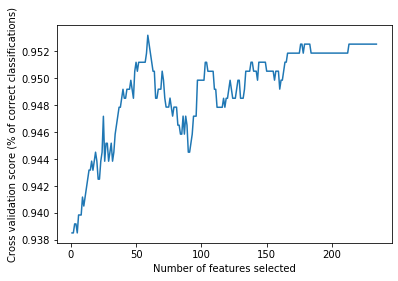

In [16]:
import warnings
warnings.filterwarnings('ignore')

### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv = RFECV(clf, step=1, cv=5)
rfecv.fit(X_selection_preprocessed, y_selection)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [17]:
### Show all selected features
selected_features = all_processed_cols[rfecv.support_]
print(selected_features)

['age' 'num_emp' 'weeks_worked' 'class_worker_ Federal government'
 'class_worker_ Self-employed-not incorporated' 'det_ind_code_5'
 'det_ind_code_6' 'det_ind_code_9' 'det_ind_code_15' 'det_ind_code_18'
 'det_ind_code_22' 'det_ind_code_29' 'det_ind_code_33' 'det_ind_code_34'
 'det_ind_code_35' 'det_ind_code_38' 'det_ind_code_39' 'det_ind_code_40'
 'det_ind_code_47' 'det_occ_code_2' 'det_occ_code_7' 'det_occ_code_10'
 'det_occ_code_11' 'det_occ_code_12' 'det_occ_code_18' 'det_occ_code_26'
 'det_occ_code_42' 'det_occ_code_43' 'education_ 10th grade'
 'education_ 5th or 6th grade' 'education_ 7th and 8th grade'
 'education_ 9th grade' 'education_ Doctorate degree(PhD EdD)'
 'education_ Masters degree(MA MS MEng MEd MSW MBA)'
 'education_ Prof school degree (MD DDS DVM LLB JD)'
 'major_ind_code_ Entertainment'
 'major_ind_code_ Personal services except private HH'
 'major_ind_code_ Retail trade' 'major_ind_code_ Transportation'
 'major_occ_code_ Adm support including clerical'
 'major_occ_

In [18]:
### log 
X_selection_log = X_selection.copy()
X_selection_log['wage_per_hour'] = np.log10(X_selection_log['wage_per_hour'] + 1)
X_selection_log['capital_gains'] = np.log10(X_selection_log['capital_gains'] + 1)
X_selection_log['capital_losses'] = np.log10(X_selection_log['capital_losses'] + 1)
X_selection_log['stock_dividends'] = np.log10(X_selection_log['stock_dividends'] + 1)
X_selection_log_preprocessed = preprocessor.fit_transform(X_selection_log)


Optimal number of features : 178
Max Score : 0.9532082931172514


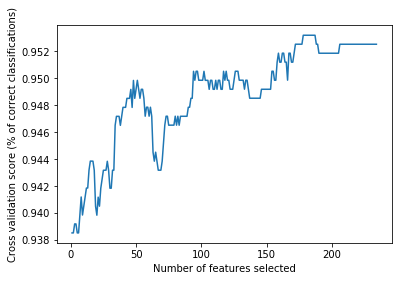

In [19]:
clf = LogisticRegression(n_jobs=-1)
rfecv_log = RFECV(clf, step=1, cv=5)
rfecv_log.fit(X_selection_log_preprocessed, y_selection)
print("Optimal number of features : %d" % rfecv_log.n_features_)
print("Max Score :", max(rfecv_log.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_log.grid_scores_) + 1), rfecv_log.grid_scores_)
plt.show()

In [24]:
### Show all selected features
X_selected = X_selection_log_preprocessed.tocsr()[:,rfecv_log.support_] #index columns of sparse matrix

selected_features = all_processed_cols[rfecv_log.support_]
print(selected_features)

['age' 'capital_gains' 'capital_losses' 'stock_dividends'
 'instance_weight' 'num_emp' 'weeks_worked'
 'class_worker_ Federal government' 'class_worker_ Local government'
 'class_worker_ Not in universe' 'class_worker_ Private'
 'class_worker_ Self-employed-incorporated'
 'class_worker_ Self-employed-not incorporated'
 'class_worker_ State government' 'det_ind_code_0' 'det_ind_code_2'
 'det_ind_code_3' 'det_ind_code_4' 'det_ind_code_5' 'det_ind_code_6'
 'det_ind_code_7' 'det_ind_code_9' 'det_ind_code_11' 'det_ind_code_12'
 'det_ind_code_13' 'det_ind_code_14' 'det_ind_code_15' 'det_ind_code_16'
 'det_ind_code_18' 'det_ind_code_19' 'det_ind_code_21' 'det_ind_code_22'
 'det_ind_code_23' 'det_ind_code_24' 'det_ind_code_26' 'det_ind_code_27'
 'det_ind_code_29' 'det_ind_code_30' 'det_ind_code_33' 'det_ind_code_34'
 'det_ind_code_35' 'det_ind_code_38' 'det_ind_code_39' 'det_ind_code_40'
 'det_ind_code_41' 'det_ind_code_44' 'det_ind_code_45' 'det_ind_code_46'
 'det_ind_code_47' 'det_ind_code_4

## Modeling and Evaluation

In [25]:
#finalDF = selection_df[selected_features]

#finalDF.info()

KeyError: "['det_occ_code_23', 'education_ Associates degree-academic program', 'marital_stat_ Separated', 'det_ind_code_30', 'full_or_part_emp_ Not in labor force', 'det_ind_code_23', 'major_ind_code_ Communications', 'vet_question_ Not in universe', 'det_ind_code_39', 'det_occ_code_41', 'det_ind_code_3', 'education_ 5th or 6th grade', 'det_ind_code_38', 'union_member_ Yes', 'hisp_origin_ All other', 'det_occ_code_6', 'citizenship_ Native- Born abroad of American Parent(s)', 'tax_filer_stat_ Single', 'major_occ_code_ Adm support including clerical', 'det_occ_code_29', 'full_or_part_emp_ Full-time schedules', 'det_ind_code_24', 'citizenship_ Native- Born in Puerto Rico or U S Outlying', 'hisp_origin_ Central or South American', 'major_occ_code_ Not in universe', 'vet_question_ Yes', 'marital_stat_ Married-spouse absent', 'education_ Children', 'major_occ_code_ Other service', 'det_occ_code_4', 'det_occ_code_32', 'det_occ_code_31', 'own_or_self_1', 'full_or_part_emp_ Unemployed full-time', 'race_ White', 'det_ind_code_5', 'full_or_part_emp_ Unemployed part- time', 'det_occ_code_34', 'major_occ_code_ Executive admin and managerial', 'det_ind_code_13', 'major_ind_code_ Transportation', 'det_ind_code_16', 'det_ind_code_34', 'det_ind_code_35', 'det_occ_code_11', 'major_occ_code_ Precision production craft & repair', 'education_ 7th and 8th grade', 'education_ 1st 2nd 3rd or 4th grade', 'hs_college_ College or university', 'education_ Prof school degree (MD DDS DVM LLB JD)', 'vet_benefits_1', 'hisp_origin_ Other Spanish', 'fam_under_18_ Not in universe', 'marital_stat_ Widowed', 'det_occ_code_21', 'vet_question_ No', 'major_occ_code_ Professional specialty', 'education_ Associates degree-occup /vocational', 'det_ind_code_26', 'unemp_reason_ Job loser - on layoff', 'marital_stat_ Divorced', 'major_occ_code_ Sales', 'major_ind_code_ Social services', 'race_ Black', 'education_ 10th grade', 'major_ind_code_ Construction', 'det_occ_code_0', 'det_occ_code_43', 'det_ind_code_15', 'det_ind_code_12', 'major_occ_code_ Farming forestry and fishing', 'det_occ_code_39', 'det_occ_code_3', 'major_occ_code_ Technicians and related support', 'education_ 9th grade', 'own_or_self_0', 'det_occ_code_18', 'class_worker_ Local government', 'det_ind_code_14', 'fam_under_18_ Mother only present', 'det_occ_code_44', 'det_occ_code_9', 'education_ 11th grade', 'major_ind_code_ Agriculture', 'major_ind_code_ Entertainment', 'det_ind_code_46', 'own_or_self_2', 'union_member_ Not in universe', 'major_ind_code_ Retail trade', 'det_occ_code_37', 'det_occ_code_19', 'det_ind_code_21', 'hs_college_ Not in universe', 'unemp_reason_ Job leaver', 'major_ind_code_ Not in universe or children', 'unemp_reason_ Not in universe', 'det_occ_code_40', 'major_occ_code_ Machine operators assmblrs & inspctrs', 'hisp_origin_ Puerto Rican', 'det_occ_code_42', 'det_occ_code_24', 'det_occ_code_8', 'det_ind_code_2', 'fam_under_18_ Both parents present', 'vet_benefits_2', 'major_ind_code_ Manufacturing-nondurable goods', 'det_occ_code_36', 'marital_stat_ Married-civilian spouse present', 'det_ind_code_27', 'det_occ_code_12', 'class_worker_ Self-employed-not incorporated', 'det_ind_code_41', 'major_ind_code_ Public administration', 'det_occ_code_5', 'det_occ_code_7', 'det_occ_code_26', 'det_occ_code_45', 'det_ind_code_19', 'det_occ_code_14', 'det_ind_code_49', 'vet_benefits_0', 'class_worker_ Federal government', 'det_ind_code_9', 'major_occ_code_ Transportation and material moving', 'education_ Masters degree(MA MS MEng MEd MSW MBA)', 'det_ind_code_45', 'det_occ_code_10', 'det_ind_code_7', 'hisp_origin_ Mexican (Mexicano)', 'det_occ_code_15', 'education_ 12th grade no diploma', 'class_worker_ Self-employed-incorporated', 'det_ind_code_40', 'unemp_reason_ Other job loser', 'det_ind_code_11', 'det_ind_code_47', 'major_ind_code_ Business and repair services', 'union_member_ No', 'tax_filer_stat_ Nonfiler', 'sex_ Male', 'det_occ_code_16', 'det_ind_code_44', 'citizenship_ Native- Born in the United States', 'det_ind_code_22', 'det_ind_code_0', 'marital_stat_ Never married', 'major_ind_code_ Manufacturing-durable goods', 'det_ind_code_29', 'major_ind_code_ Personal services except private HH', 'sex_ Female', 'full_or_part_emp_ Children or Armed Forces', 'race_ Asian or Pacific Islander', 'det_occ_code_13', 'det_ind_code_33', 'det_ind_code_18', 'education_ Doctorate degree(PhD EdD)', 'det_ind_code_6', 'det_ind_code_4', 'det_ind_code_48', 'tax_filer_stat_ Joint one under 65 & one 65+', 'class_worker_ Not in universe', 'class_worker_ State government', 'det_occ_code_2', 'hisp_origin_ Cuban', 'full_or_part_emp_ PT for non-econ reasons usually FT', 'class_worker_ Private', 'major_ind_code_ Other professional services', 'det_occ_code_35', 'major_ind_code_ Hospital services', 'det_ind_code_50', 'det_occ_code_30'] not in index"

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt

In [30]:
#### Using the classification_pipeline function Decision Tree
%time
classifier = DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [2, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1,2,3],
    
}

CV = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV.fit(X_selected, y_selection)
    
print('Best Score: {s}'.format(s=CV.best_score_))
print('Best Parameters: {p}'.format(p=CV.best_params_))  

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs
Best Score: 0.9431818181818182
Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'splitter': 'random'}


In [31]:
#Feature importance graph
#imp = dt_clf.feature_importances_

#Plt
#plt.bar(range(len(imp)),imp)

In [37]:
#Indy

from sklearn.ensemble import AdaBoostClassifier
%time
#### Using the classification_pipeline function Logistic regression
classifier = LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    #'penalty' : ['l1', 'l2',],
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter': [99999],
}

CV_lr = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_lr.fit(X_selected, y_selection)
    
print('Best Score: {s}'.format(s=CV_lr.best_score_))
print('Best Parameters: {p}'.format(p=CV_lr.best_params_))  

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Best Score: 0.9545454545454546
Best Parameters: {'class_weight': None, 'max_iter': 99999, 'solver': 'lbfgs'}


In [38]:
#### Using the classification_pipeline function KNN
from sklearn.neighbors import KNeighborsClassifier

%time
classifier = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [5, 10,100,1000],
}

CV_knn = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_knn.fit(X_selected, y_selection)

print('Best Score: {s}'.format(s=CV_knn.best_score_))
print('Best Parameters: {p}'.format(p=CV_knn.best_params_))

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs
Best Score: 0.9438502673796791
Best Parameters: {'n_neighbors': 5}


In [41]:
#### Using the classification_pipeline function AdaBqqst
%time
import warnings
warnings.filterwarnings('ignore')
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
param_grid = { 
    'n_estimators': [50, 100, 200],
    'learning_rate': [.1, .5, 1],
    'algorithm': ['SAMME.R', 'SAMME']
}

CV_ada = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_ada.fit(X_selected, y_selection)

print('Best Score: {s}'.format(s=CV_ada.best_score_))
print('Best Parameters: {p}'.format(p=CV_ada.best_params_)) 

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.8 µs


exception calling callback for <Future at 0x7fa13316e850 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [42]:
#Jason Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

%time

param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'learning_rate' : [0.001, 0.1, 0.5, 1],
    'max_depth': [1,2,3],
}

gbc = GradientBoostingClassifier(random_state=1)


CV_gbc = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_gbc.fit(X_selected, y_selection)

print('Best Score: {s}'.format(s=CV_gbc.best_score_))
print('Best Parameters: {p}'.format(p=CV_gbc.best_params_))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 68.9 µs


exception calling callback for <Future at 0x7fa132897710 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))

exception calling callback for <Future at 0x7fa13289c250 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

### Model and Evaluation 1

### Model and Evaluation 2

### Model and Evaluation 3

### Model and Evaluation 4

### Model and Evaluation 5

### Model and Evaluation 6

### Deployment

### Exceptional Work